In [0]:
!pip install -U -q kaggle
!mkdir -p ~/.kaggle
from google.colab import files
import os
%tensorflow_version 1.x
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.layers import BatchNormalization, Activation
from tensorflow.python.keras.optimizers import Adam, RMSprop
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 

In [0]:
files.upload()

{}

In [0]:
image_size = 299
batch_size = 32

In [0]:
!cp kaggle.json ~/.kaggle/

In [0]:
!kaggle datasets list

ref                                                            title                                                size  lastUpdated          downloadCount  
-------------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  
allen-institute-for-ai/CORD-19-research-challenge              COVID-19 Open Research Dataset Challenge (CORD-19)    1GB  2020-04-03 22:53:52          47655  
roche-data-science-coalition/uncover                           UNCOVER COVID-19 Challenge                          123MB  2020-04-08 22:04:30           2441  
fireballbyedimyrnmom/us-counties-covid-19-dataset              US counties COVID 19 dataset                        380KB  2020-04-10 20:59:12           2732  
ryanxjhan/cbc-news-coronavirus-articles-march-26               CBC News Coronavirus/COVID-19 Articles (NLP)          6MB  2020-03-27 23:23:07            579  
bappekim/air-pollution-in-seoul               

kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

In [0]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

chest-xray-pneumonia.zip: Skipping, found more recently modified local copy (use --force to force download)


In [0]:
!chmod 600 /root/.kaggle/kaggle.json

In [0]:
!ls

 chest_xray		   'kaggle (1).json'   sample_data
 chest-xray-pneumonia.zip  'kaggle (2).json'
 inceptionv3_best.h5	    kaggle.json


In [0]:
!unzip chest-xray-pneumonia.zip

Archive:  chest-xray-pneumonia.zip
replace chest_xray/__MACOSX/._chest_xray? [y]es, [n]o, [A]ll, [N]one, [r]ename: Т
error:  invalid response [Т]
replace chest_xray/__MACOSX/._chest_xray? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [0]:
!ls chest_xray/val/PNEUMONIA -1 | wc -l

8


**TEST:**: NORMAL — 234, PNEUMONIA — 390

**TRAIN:** NORMAL — 1341, PNEUMONIA — 3875

**VALIDATION:** NORMAL — 8, PNEUMONIA — 8



In [0]:
train_dir = 'chest_xray/train'
test_dir = 'chest_xray/test'
input_shape = (image_size,image_size,3)

In [0]:
train_datagen = ImageDataGenerator(rescale=1. / 255,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    fill_mode='nearest')

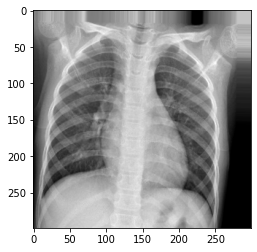

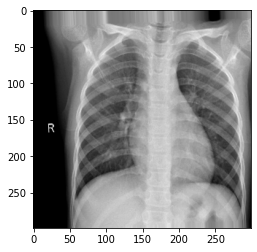

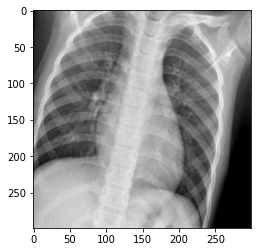

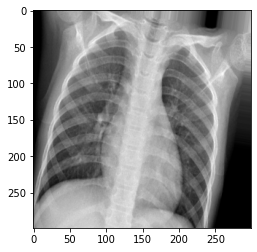

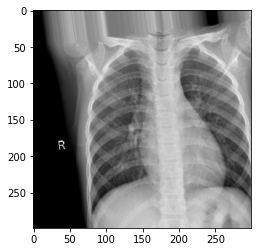

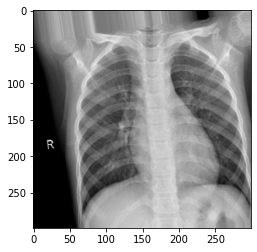

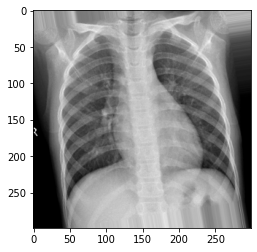

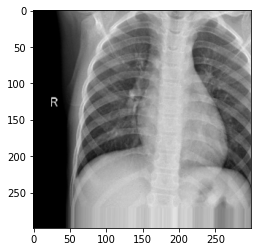

In [0]:
img_path = 'chest_xray/test/NORMAL/NORMAL2-IM-0380-0001.jpeg'
img = image.load_img(img_path, target_size=(image_size, image_size))
x = image.img_to_array(img)
x = x.reshape((1,) + x.shape)
i = 0
for batch in train_datagen.flow(x, batch_size=1):
    plt.figure(i)
    imgplot = plt.imshow(image.array_to_img(batch[0]))
    i += 1
    if i==8:
      break;
plt.show()

In [0]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='binary')

Found 5216 images belonging to 2 classes.


In [0]:
test_datagen = ImageDataGenerator(rescale=1. / 255)

In [0]:
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='binary')

Found 624 images belonging to 2 classes.


In [0]:
pretrained_model = InceptionV3(weights='imagenet', include_top=False)

In [0]:
x = pretrained_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)
model = Model(inputs=pretrained_model.input, outputs=predictions)

In [0]:
model.compile(loss='binary_crossentropy',
              optimizer = RMSprop(lr = 1e-4), 
              metrics=['accuracy'])

In [0]:
filepath="inceptionv3_best.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, 
                             save_best_only=True, mode='max')
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)
callbacks_list = [checkpoint, learning_rate_reduction]

In [0]:
steps_per_epoch = 40
history = model.fit_generator(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    validation_data=test_generator,
    validation_steps=5,
    callbacks=callbacks_list,
    epochs=20,
    verbose=1)

Epoch 1/20
 5/40 [==>...........................] - ETA: 15s - loss: 0.6005 - acc: 0.7125
Epoch 00001: val_acc improved from 0.47500 to 0.71250, saving model to inceptionv3_best.h5
40/40 [==============================] - 76s 2s/step - loss: 0.1361 - acc: 0.9578 - val_loss: 0.6005 - val_acc: 0.7125
Epoch 2/20
 5/40 [==>...........................] - ETA: 16s - loss: 0.5774 - acc: 0.7812
Epoch 00002: val_acc improved from 0.71250 to 0.78125, saving model to inceptionv3_best.h5
40/40 [==============================] - 32s 791ms/step - loss: 0.1228 - acc: 0.9617 - val_loss: 0.5774 - val_acc: 0.7812
Epoch 3/20
 5/40 [==>...........................] - ETA: 16s - loss: 0.4049 - acc: 0.8625
Epoch 00003: val_acc improved from 0.78125 to 0.86250, saving model to inceptionv3_best.h5
40/40 [==============================] - 39s 965ms/step - loss: 0.1325 - acc: 0.9539 - val_loss: 0.4049 - val_acc: 0.8625
Epoch 4/20
 5/40 [==>...........................] - ETA: 16s - loss: 0.5154 - acc: 0.8500
Epoc

In [0]:
model.load_weights("inceptionv3_best.h5")

In [0]:
pretrained_model.trainable = False
for layer in model.layers[:249]:
   layer.trainable = False
for layer in model.layers[249:]:
   layer.trainable = True

In [0]:
model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(lr=1e-4), 
              metrics=['accuracy'])

In [0]:
filepath="inceptionv3_fine_tuned.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint, learning_rate_reduction]

In [0]:
steps_per_epoch = 40
history = model.fit_generator(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    validation_data=test_generator,
    validation_steps=5,
    callbacks=callbacks_list,
    epochs=5,
    verbose=2)

Epoch 1/5
Epoch 1/5

Epoch 00001: val_acc improved from -inf to 0.93125, saving model to inceptionv3_fine_tuned.h5
40/40 - 49s - loss: 0.0091 - acc: 0.9961 - val_loss: 0.3676 - val_acc: 0.9312
Epoch 2/5
Epoch 1/5

Epoch 00002: val_acc did not improve from 0.93125
40/40 - 29s - loss: 0.0129 - acc: 0.9945 - val_loss: 0.3936 - val_acc: 0.9250
Epoch 3/5
Epoch 1/5

Epoch 00003: val_acc did not improve from 0.93125
40/40 - 35s - loss: 0.0120 - acc: 0.9969 - val_loss: 0.3733 - val_acc: 0.9187
Epoch 4/5
Epoch 1/5

Epoch 00004: val_acc did not improve from 0.93125

Epoch 00004: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
40/40 - 37s - loss: 0.0217 - acc: 0.9953 - val_loss: 0.4350 - val_acc: 0.9187
Epoch 5/5
Epoch 1/5

Epoch 00005: val_acc improved from 0.93125 to 0.93750, saving model to inceptionv3_fine_tuned.h5
40/40 - 34s - loss: 0.0062 - acc: 0.9977 - val_loss: 0.4237 - val_acc: 0.9375


In [0]:
model = load_model("inceptionv3_fine_tuned.h5")

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


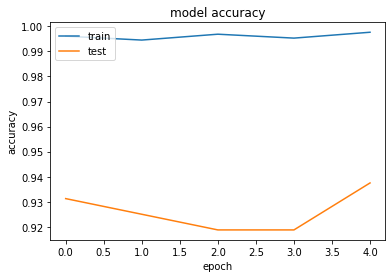

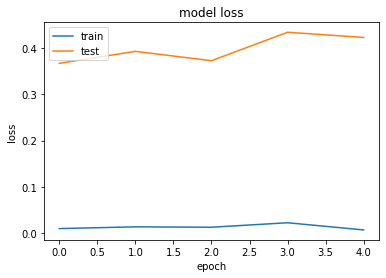

In [0]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')

plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [0]:
from sklearn.metrics import classification_report, confusion_matrix
import itertools

Found 16 images belonging to 2 classes.


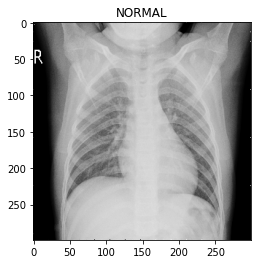

[[0.00197325]]


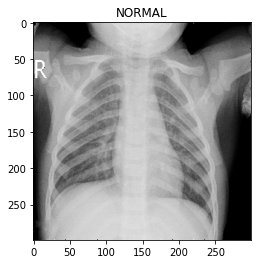

[[7.162855e-05]]


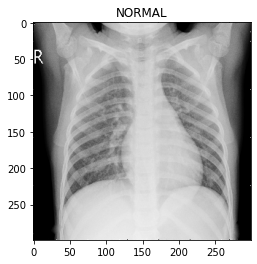

[[0.00173904]]


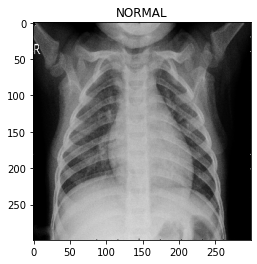

[[6.2646846e-05]]


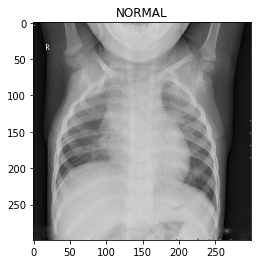

[[0.00015106]]


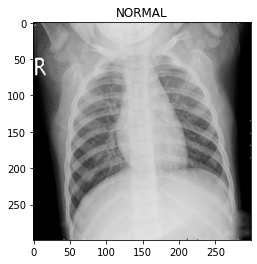

[[0.00823251]]


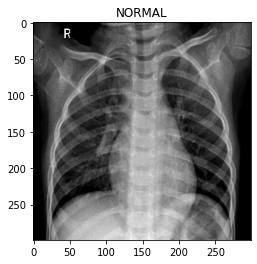

[[0.]]


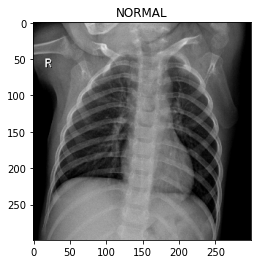

[[0.]]


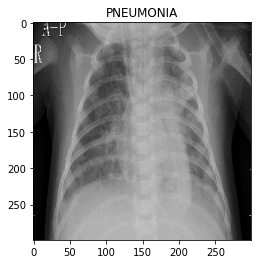

[[0.9999831]]


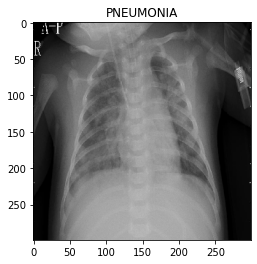

[[0.99985945]]


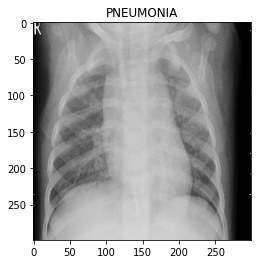

[[0.9787143]]


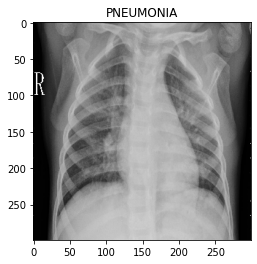

[[0.99978596]]


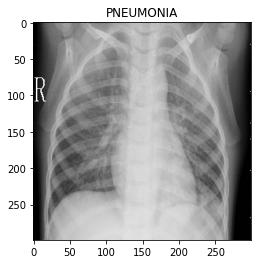

[[0.9987117]]


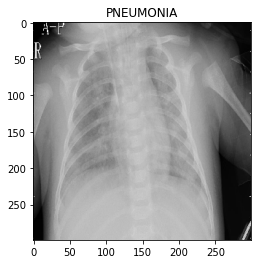

[[0.999966]]


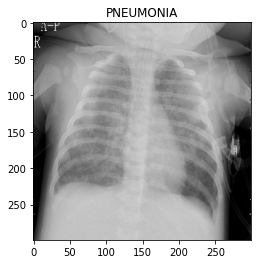

[[0.99974805]]


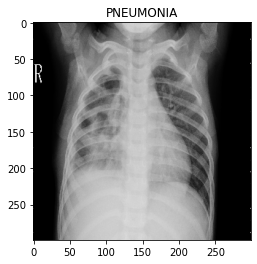

[[0.9998566]]


In [0]:
val_dir = 'chest_xray/val'
val_datagen = image.ImageDataGenerator(rescale=1. / 255)
val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='binary')
true_res = list()
predicted_res = list()

for i in val_generator.filenames:
    path = i.split("/")
    if (path[0] == "NORMAL"):
      true_res.append(0)
    else:
      true_res.append(1)
    path_im = "chest_xray/val/" + i
    img = image.load_img(path_im, target_size=(image_size, image_size))
    plt.imshow(img)
    plt.title(path[0])
    plt.show()  
    x = image.img_to_array(img)
    x /=255
    x = np.expand_dims(x, axis=0)
    prediction = model.predict(x)
    print(prediction)
    if (prediction <=0.5):
      predicted_res.append(0)
    else:
      predicted_res.append(1)

In [0]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[8 0]
 [0 8]]


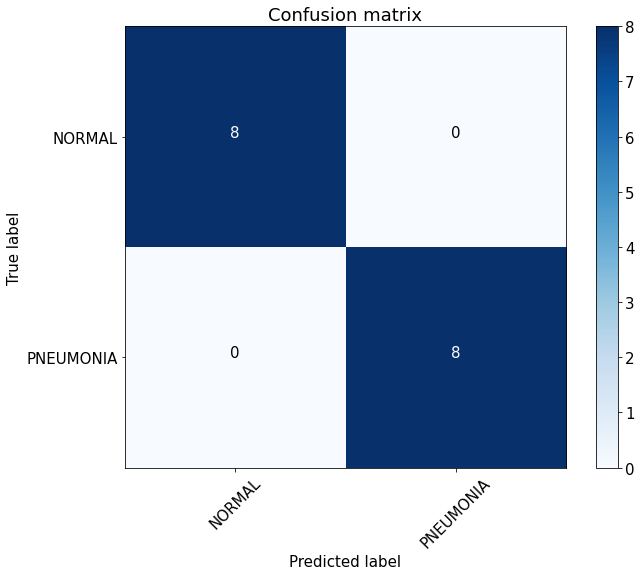

In [0]:
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(true_res,predicted_res)
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=["NORMAL", "PNEUMONIA"],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()